# [CompuCell3D](http://compucell3d.org) in a Jupyter Notebook

> CompuCell3D is an open-source simulation environment for multi-cell, single-cell-based modeling of tissues, organs and organisms.

>It uses Cellular Potts Model to model cell behavior.

>This project is funded by the NIH and EPA.

>Compucell3D is led by Maciej Swat (IU), James Glazier(IU) and Roshan D'Souza (U.Wisc. Milwaukee) 

## Structure of the Simulations directory tree

* DATA_ROOT
    - ...
    - Sim2_cc3d_dd_MM_yyyy_hh_mm_ss
        * LatticeData
            - vtk_files ... **Here are the data**
        * Simulation
            - xml & python files ...
    
    
    - ...
    


### Parsing xml and python files

This is used for parameters management

In [1]:
import os
from xml.etree import ElementTree
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import vtk
from vtk.util.numpy_support import vtk_to_numpy

from skimage.filters import rank
from skimage.morphology import disk


from skimage import filters
from skimage.future import graph

from skimage import measure
from scipy import special

In [2]:
%matplotlib inline


In [3]:
%pdb

Automatic pdb calling has been turned ON


In [4]:
# TODO: do a widget for that
DATA_ROOT = '/home/guillaume/Projets/NeuroBlasts/CC3D_sims/'

folder_num = 0


data_dirs = os.listdir(DATA_ROOT)
data_dirs = [os.path.join(DATA_ROOT, d) for d in data_dirs]
data_dirs = [d for d in data_dirs if os.path.isdir(d)]


data_dir = data_dirs[folder_num]

print('***************\n')
print('Using: #{} - {}\n'.format(folder_num, data_dir))

def parse_cc3d(data_dir, simname):
    
    sim_dict = {}
    sim_str = []

    xml_file = os.path.join(data_dir+'/Simulation/{}.xml'.format(simname))
    py_file = os.path.join(data_dir+'/Simulation/{}Steppables.py'.format(simname))

    xml_tree = ElementTree.ElementTree(file=xml_file)
    xml_root = xml_tree.getroot()

    for child in xml_root:

        if child.tag == 'Potts':
            steps = int(child.find('Steps').text)
            dim = {k: int(v) for k, v 
                   in child.find('Dimensions').items()}
            sim_dict['dim'] = dim
            sim_dict['steps'] = steps
        elif child.get('Name') == 'Contact':
            energies = child.findall('Energy')
            energies = {'{}-{}'.format(energy.attrib['Type1'],
                                       energy.attrib['Type2']):
                        float(energy.text) for energy in energies}

    sim_dict['energies'] = energies
    
    sim_str.append('\n***************')
    sim_str.append('**  Energies **\n')
    for k, v in energies.items():
        sim_str.append('{}: {}'.format(k, v))
    

    pysettings = []
    
    with open(py_file) as pf:
        start_parse = False
        for line in pf.readlines():
            if line.startswith('# <parameter settings>'):
                start_parse = True
            elif (start_parse 
                  and not line.startswith('#')
                  and len(line) > 3):
                pysettings.append(line[:-1])
            elif line.startswith('# </parameter settings>'):
                break
    
    
    sim_dict['pysettings'] = pysettings
    
    sim_str.append('***************\n')
    sim_str.append('**  python set variables: **')
    for p in pysettings:
        sim_str.append(p)

    vtk_dir = os.path.join(data_dir,'LatticeData')

    vtk_files = [os.path.join(vtk_dir, f) 
                 for f in os.listdir(vtk_dir)
                 if f.endswith('.vtk')]
    vtk_files.sort()
    sim_dict['vtk_files'] = vtk_files
    
    sim_str.append('\n***************')
    sim_str.append('**  VTK files **\n')
    sim_str.append('starts: {}\n stops: {}'.format(vtk_files[0], vtk_files[-1]))
    return sim_dict, sim_str

sim_dict, sim_str = parse_cc3d(data_dir, simname='Sim2')

sim_dict['pysettings']
exec(' '.join(sim_dict['pysettings'])) #of course this is unsafe, I know it
sim_dict['py_params'] = params.copy()

import json
with file(data_dir+'.json', 'w') as fp:
    json.dump(sim_dict, fp)

for l in sim_str: print(l)

***************

Using: #0 - /home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_cc3d_09_17_2015_15_50_28


***************
**  Energies **

Medium-CancerStemCell: 10.0
CancerStemCell-CancerStemCell: 1.0
CancerStemCell-NonCancerous: 10.0
NonCancerous-NonCancerous: 1.0
Medium-Medium: 10.0
Medium-NonCancerous: 10.0
***************

**  python set variables: **
params = {
    'growth_rate': 1.,
    'P_sr': 0.4,
    'P_ar': 0.2,
    'cell_critical_volume': 50,
    'targetVolume': 25,
    'lambdaVolume': 10,
    'prolif_potential': 4,
    }

***************
**  VTK files **

starts: /home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_cc3d_09_17_2015_15_50_28/LatticeData/Step_000.vtk
 stops: /home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_cc3d_09_17_2015_15_50_28/LatticeData/Step_490.vtk


In [5]:
def parse_vtk(vtk_file, sim_dict, data_fields):
    
    dim = sim_dict['dim']
    reader = vtk.vtkStructuredPointsReader()
    #reader = vtkUnstructuredGridReader()
    reader.SetFileName(vtk_file)
    reader.Update()
    field_data = reader.GetOutput()
    out_data = {}
    for data_field in data_fields:
        out_data[data_field] = vtk_to_numpy(
            field_data.GetPointData().GetArray(data_field)).reshape((dim['x'], dim['y']))
    reader.CloseVTKFile()
    return out_data    
    
field_names = ['CellType', 'CellId', 'CellAge'] # 'ClusterId' is not used yet

def parse_all_vtks(vtk_files, sim_dict, field_names):
    num_steps = len(vtk_files)
    dim = sim_dict['dim']
    data_fields = {field: np.zeros((num_steps, dim['x'], dim['y']))
                   for field in field_names}
    step_values = []
    for i, vtk_file in enumerate(vtk_files):
        step_values.append(int(vtk_file.split('.')[0][-3:]))
        frame_data = parse_vtk(vtk_file, sim_dict, field_names)
        for key, val in frame_data.items():
            data_fields[key][i] = val
    return data_fields, np.array(step_values)

data_fields, step_values = parse_all_vtks(sim_dict['vtk_files'], sim_dict, field_names)


In [6]:

def get_pix_entropy():
    pix_entropy = rank.entropy(cell_type_field.astype(np.uint8), disk(2))

    
data_fields['PixelEntropy'] = np.array([rank.entropy(cell_type.astype(np.uint8), disk(2))
                                       for cell_type in data_fields['CellType']])


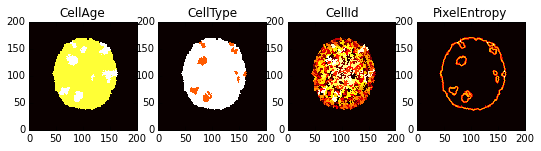

In [7]:
dpi = 90. # pixel per inch 
pix_width = 800
pix_height = 300

%matplotlib inline
vtk_fnum = 15
f_size_i = (pix_width/dpi, pix_height/dpi)


fig, axes = plt.subplots(1, len(data_fields))
fig.set_size_inches(f_size_i)


for ax, (name, field) in zip(axes, data_fields.items()):
    ax.imshow(field[vtk_fnum], cmap='hot', origin='lower', interpolation='nearest')
    ax.set_title(name, fontdict={'fontsize':12})


In [ ]:
def get_idxs(data_fields, step_values):
    cell_types, cell_ids = data_fields['CellType'], data_fields['CellId']
    e_idx = []
    v_idx = []
    for mcs, cell_type, cell_id in zip(step_values, cell_types, cell_ids):
        rag = graph.rag_mean_color(cell_type, cell_id)
        direct = [(mcs, s, t) for s, t in rag.edges()]
        fliped = [(mcs, t, s) for s, t in rag.edges()]
        e_idx.extend(direct + fliped)
        v_idx.extend([(mcs, cell_id) for cell_id in rag.nodes()])

    e_idx = pd.MultiIndex.from_tuples(e_idx, 
                                      names=['t', 'srce', 'trgt'])
    v_idx = pd.MultiIndex.from_tuples(v_idx, 
                                      names=['t', 'cell'])
    return v_idx, e_idx

v_idx, e_idx = get_idxs(data_fields, step_values)

In [ ]:

    
cell_data = ['type', 'age', 'area', 'cx', 'cy']
    
cell_df = pd.DataFrame(index=v_idx, columns=cell_data)
for i, mcs in enumerate(step_values):
    cell_type = data_fields['CellType'][i]
    cell_id = data_fields['CellId'][i]
    cell_age = data_fields['CellAge'][i]
    properties = measure.regionprops(cell_id.astype(np.int))
    for p in properties:
        lbl = p['label']
        cell_df.loc[(mcs, lbl), 'area'] = p['area']
        cx, cy = p['centroid']
        cell_df.loc[(mcs, lbl), 'cx'] = cx
        cell_df.loc[(mcs, lbl), 'cy'] = cy
        
        cell_df.loc[(mcs, lbl), 'age'] = cell_age[int(cx), int(cy)]
        cell_df.loc[(mcs, lbl), 'type'] = cell_type[int(cx), int(cy)]
        
    

In [ ]:
fig, ax = plt.subplots()
size = cell_df.age.values.astype(np.float) * 20 + 10
ax.scatter(cell_df.cx.values, cell_df.cy.values,
           s=size, c=cell_df.type.values, cmap='hot', alpha=0.5);

In [ ]:
cell_df.xs(1, level='cell').head()

In [ ]:
edge_columns = ['srce_type', 'trgt_type']
edge_df = pd.DataFrame(index=e_idx, columns=edge_columns)

In [ ]:
t_idx = e_idx.get_level_values(level='t')
srce_idx = e_idx.get_level_values(level='srce')
trgt_idx = e_idx.get_level_values(level='trgt')

srce_idx = pd.MultiIndex.from_arrays([t_idx, srce_idx], names=['t', 'cell'])
trgt_idx = pd.MultiIndex.from_arrays([t_idx, trgt_idx], names=['t', 'cell'])


In [ ]:
edge_df['srce_type'] = cell_df['type'].loc[srce_idx].values
edge_df['trgt_type'] = cell_df['type'].loc[trgt_idx].values


In [ ]:
edge_df['type_diff'] = edge_df.trgt_type == edge_df.srce_type

In [ ]:
edge_df = edge_df.drop(0, level='srce')
edge_df = edge_df.drop(0, level='trgt')


In [ ]:
pis = edge_df.type_diff.groupby(level=['t', 'srce']).apply(lambda df: special.binom(df.size, df.sum())/2**df.size)
pis.index.names = ['t', 'cell']
cell_df['pis'] = pis
entropy = - pis * np.log2(pis)
cell_df['entropy'] = entropy
cell_df.head()

In [ ]:
fig, ax = plt.subplots()
size = cell_df.age.values.astype(np.float) * 20 + 10
ax.scatter(cell_df.cx.values, cell_df.cy.values,
           s=size, c=cell_df.entropy.values, cmap='hot', alpha=0.5);

In [ ]:
fig, ax = plt.subplots()
for idx, cell in cell_df.groupby(level='cell'):
    cell.plot(cell.age, ax=ax)
    if idx > 10: break

In [ ]:
entropy_field = cell_type.copy().astype(np.float)
for lbl in v_idx:
    entropy_field[cell_id == lbl] = entropy.loc[lbl]

entropy_field = entropy_field / entropy_field.max()

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(cell_type[:100, :100], origin='lower', interpolation='nearest')
axes[1].imshow(entropy_field[:100, :100], cmap='hot', origin='lower', interpolation='nearest')

In [ ]:
entropy.loc[1:].mean()

In [ ]:
axes[1].imshow(entropy_field[:100, :100] * (cell_type[:100, :100] == 1),
               cmap='hot', origin='lower', interpolation='nearest')

In [ ]:
fig